In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()
weight = {}
weight_sum = {}
NEvents = {}
total_signal = 0

analyzer_version = "/v1/vBDT4/"
data_version = '/v5/vBDT4/'
ntupler_version ='V1p17'

data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/'+data_version+'/normalized/'
fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+ntupler_version+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
                    
fpath['MC_ggH_HToSS_SToEE_ms0p4_pl500'] = mc_path+'ggH_HToSS_SToEE_ms0p4_pl500_1pb_weighted.root'


for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    weight[k] = tree[k]["weight"].array()
    weight_sum[k] = np.sum(weight[k])
    print("NEvents",k,NEvents[k], weight_sum[k], len(weight[k]))
    if not k == 'data': total_signal += NEvents[k]
    
print(total_signal)


NEvents data 22763250.0 2683.0 2683
NEvents MC_ggH_HToSS_SToEE_ms0p4_pl500 21468808.0 0.24187624 4961
21468808.0


# Helper Functions & loading packages

In [3]:
# Imports
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import math
import pickle as pickle
import ROOT as root
import os
import shlex
import uproot
import seaborn as sns

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

variables = [
            ['cscRechitClusterNStation10', 'cscRechitClusterNStation10', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation10', 'cscRechitClusterAvgStation10', 'cluster station', 30, 1, 4],
            ]

## load root files to dataframes & weight

In [22]:
lumi_year = {
    'Summer16': 35.92,
    'Fall17':41.53,
    'Fall18':59.74,
}

# timespread_cut = 2.0


weight_signal = []
df_signal_list  = []
nRechit_list = []
veto_list = []
# timespread_list = []
for key in tree.keys():
    if not key[:2] == 'MC':continue
    df_signal_temp = uproot.open(fpath[key])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)
    df_signal_list.append(df_signal_temp)
df_signal = pd.concat(df_signal_list)
df_bkg = uproot.open(fpath['data'])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)
weight_bkg = np.ones((len(df_bkg,)))
weight_signal = np.ones((len(df_signal,)))

print("values in signal missing: ", df_signal.isnull().values.any())
print("values in bkg missing: ", df_bkg.isnull().values.any())

x = np.abs(np.concatenate([df_bkg,df_signal]))
y = np.concatenate([np.zeros(len(df_bkg)),np.ones(len(df_signal))])
weight_signal = weight_signal/np.sum(weight_signal) * np.sum(weight_bkg)


weight = np.hstack((weight_bkg, weight_signal))

assert(len(x) == len(y) == len(weight))

print("Number of signal events: "+ str(len(df_signal)))
print("Number of background events: "+str(len(df_bkg)))
print("Sum of weight for signal events: "+ str(np.sum(weight_signal)))
print("Sum of weight for background events: "+str(len(df_bkg)))

indices = np.arange(len(y))

MC_ggH_HToSS_SToEE_ms0p4_pl500
values in signal missing:  False
values in bkg missing:  False
Number of signal events: 4966
Number of background events: 2687
Sum of weight for signal events: 2687.000000000001
Sum of weight for background events: 2687


### plot input variables

['cscRechitClusterNStation10', 'cscRechitClusterNStation10', '$N_{station}$', 5, 0, 5]
['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\\eta$', 25, 0.5, 2.5]
['cscRechitClusterAvgStation10', 'cscRechitClusterAvgStation10', 'cluster station', 30, 1, 4]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


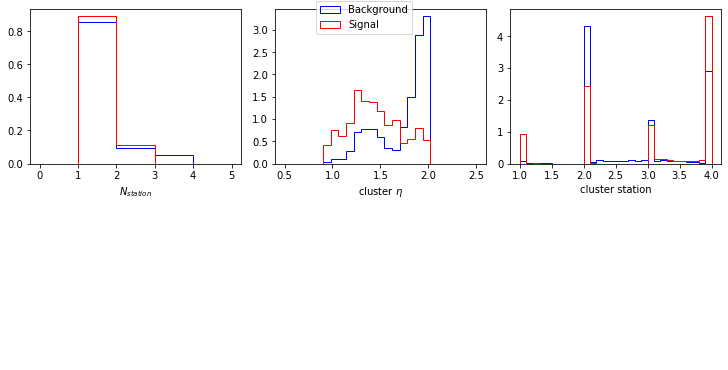

In [23]:
columns = 3
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(10,5), constrained_layout=True)
trim_axs(axs, len(variables))

r = 0
c = 0
for i, var in enumerate(variables):
    print(variables[i])
    bkg = axs[r,c].hist(x[:,i][y==0], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'b')
    sig = axs[r,c].hist(x[:,i][y==1], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Signal', color = 'r')
    axs[r,c].set_xlabel(variables[i][2])
    if c == columns-1:
        c = 0
        r+=1
    else:c+=1
fig1.legend([bkg, sig],     # The line objects
           labels=['Background', 'Signal'],   # The labels for each line
           loc="upper center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           )

# train

In [24]:
# split data into train and test sets
seed = 7
test_size = 0.2
sample_size = 1.0
# x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices,train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)
x_train, x_test, y_train, y_test, indices_train, indices_test, weight_train, weight_test\
    = train_test_split(x, y,indices, weight, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

In [25]:
# fit model no training data
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=1, n_jobs=4, reg_lambda=1.0)
model.fit(x_train, y_train, sample_weight=weight_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
# make predictions for test data
y_pred = model.predict_proba(x_test)[:, 1]
y_pred_train = model.predict_proba(x_train)[:, 1]

predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



Accuracy: 77.53%


In [ ]:
# save trained BDT model

bdt_name = 'bdt_v1'
import pickle
pickle.dump(model, open(bdt_name+".pickle", "wb"))

### cut based

In [27]:
y_pred_cut = y*0.0

# split Nstation ==1 and different avg station, original version, v3
cond2 = np.logical_and(x[:,2]==2, x[:,1] < 1.7)
cond3 = np.logical_and(x[:,2]==3, x[:,1] < 1.8)
cond4 = np.logical_and(x[:,2]==4, x[:,1] < 1.9)
cond1 = np.logical_and(x[:,0]==1, np.logical_or(np.logical_or(x[:,2]==1, cond2), np.logical_or(cond3, cond4)))
cond2 = np.logical_and(x[:, 0] > 1, x[:,1] < 1.9)
cond = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))


y_pred_cut[cond] = 1
predictions = [round(value) for value in y_pred_cut]
accuracy = accuracy_score(y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


# calculate signal efficiency/background efficiency
print("signal efficiency: ", np.count_nonzero(np.logical_and(cond, y))/np.count_nonzero(y))
print("bkg efficiency: ", np.count_nonzero(np.logical_and(cond, y==False))/np.count_nonzero(y==False))



Accuracy: 78.78%
signal efficiency:  0.8777688280306082
bkg efficiency:  0.37848902121324896


# ROC curve

In [9]:
AUC = roc_auc_score(y_test, y_pred)
print("AUC: "+str(AUC))
fpr, tpr, thr = roc_curve(y_test, y_pred)

AUC: 0.6610549047999159


## significance

In [10]:

significance = []
effSignal = []
effBkg = []
thresholds = []
ctr = 0
for i in range(len(fpr)):
    if fpr[i] > 1e-5 and tpr[i] > 1e-5:
        effSignal.append(tpr[i])
        effBkg.append(fpr[i])
        thresholds.append(thr[i])
        ctr = ctr + 1

idx_WP99 = 0
minD0p9 = 999.0
for idx in range(len(effSignal)):
    if abs(effSignal[idx] - 0.99) < minD0p9:
        idx_WP99 = idx
        minD0p9 = abs(effSignal[idx] - 0.99)

WP99_threshold = thresholds[idx_WP99]
WP99_effSignal = effSignal[idx_WP99]
WP99_effBkg = effBkg[idx_WP99]

print("WP99_threshold: "+str(WP99_threshold))
print("WP99_effSignal: "+str(WP99_effSignal))
print("WP99_effBkg: "+str(WP99_effBkg))

idx_WP90 = 0
minD0p8 = 999.0
for idx in range(len(effSignal)):
        if abs(effSignal[idx] - 0.9) < minD0p8:
                idx_WP90 = idx
                minD0p8 = abs(effSignal[idx] - 0.9)

WP90_threshold = thresholds[idx_WP90]
WP90_effSignal = effSignal[idx_WP90]
WP90_effBkg = effBkg[idx_WP90]

print("WP90_threshold: "+str(WP90_threshold))
print("WP90_effSignal: "+str(WP90_effSignal))
print("WP90_effBkg: "+str(WP90_effBkg))


WP99_threshold: 0.21021341
WP99_effSignal: 0.9889967637540453
WP99_effBkg: 0.9961759082217974
WP90_threshold: 0.2939281
WP90_effSignal: 0.8996763754045307
WP90_effBkg: 0.875717017208413


# plot roc curve

Text(0.97, 1.03, '13 TeV')

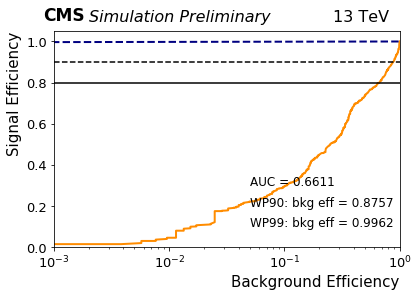

In [11]:
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)

plt.text(-0.03, 1.03, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.10, 1.03, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(0.97, 1.03, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)

# plt.legend(loc="lower right")
# plt.show()




# plot discrimination

0.15841831


Text(1.0, 1.01, '13 TeV')

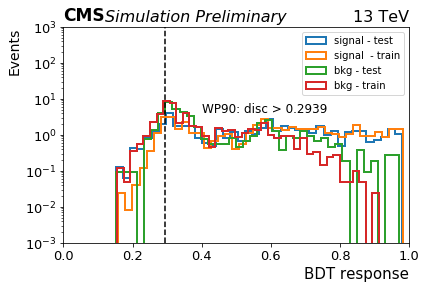

In [12]:
y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})

disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
bn= 40
plt.hist(disc_signal, density=True, bins=bn, alpha=1.0, histtype='step', lw=2, label='signal - test')
plt.hist(disc_signal_train, density=True, bins=bn, alpha=1.0, histtype='step', lw=2, label='signal  - train')
plt.hist(disc_bkg, density=True, bins=bn, alpha=1.0, histtype='step', lw=2, label='bkg - test')
plt.hist(disc_bkg_train, density=True, bins=bn, alpha=1.0, histtype='step', lw=2, label='bkg - train')

print(np.min(disc_signal_train))
plt.yscale('log')
plt.xlim([0.0, 1.0])
plt.ylim([0.001, 1000.0])
plt.legend(loc='best')
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP90_threshold, color='black', linestyle='--')
# plt.axvline(x=WP99_threshold, color='black')
plt.text(0.4,0.65,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
# plt.text(0.5,0.6,‘WP80: disc > %.4f’%WP80_threshold, fontsize=12, horizontalalignment=‘center’, verticalalignment=‘center’, transform=plt.gca().transAxes)
plt.text(0.0, 1.01, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)



[0.0, 1.0, 2.0, 3.0]
[1.0, 1.5, 2.0]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


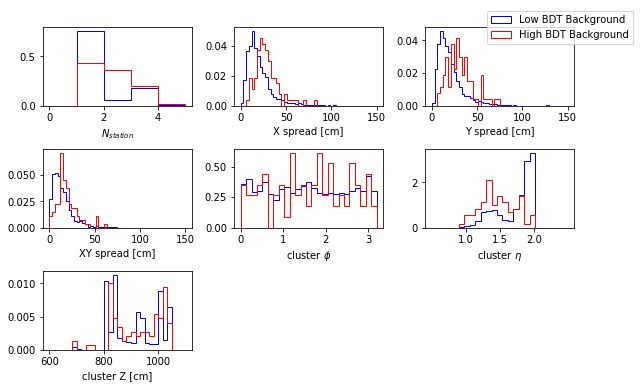

In [104]:
sig_flag = 0
lab = ['Background', 'Signal']
x_sig = x[y==sig_flag]
y_pred_sig = model.predict_proba(x_sig)[:, 1]


def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
columns = 3
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
# fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(6,8), constrained_layout=True)


# for ax, case in zip(axs, cases):
#     ax.set_title('markevery=%s' % str(case))
trim_axs(axs, len(variables))

r = 0
c = 0
for i, var in enumerate(variables):
    bkg = axs[r,c].hist(x_sig[:,i][y_pred_sig< WP90_threshold], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'b')
    sig = axs[r,c].hist(x_sig[:,i][y_pred_sig>=WP90_threshold], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Signal', color = 'r')
    axs[r,c].set_xlabel(variables[i][2])
    if i == 5:
        print(list(axs[r,c].get_xticks()))
#         axs[r,c].set_xticks(list(axs[r,c].get_xticks()) + [1.5])
        axs[r,c].set_xticks([1.0, 1.5, 2.0])
        print(list(axs[r,c].get_xticks()))

    if c == columns-1:
        c = 0
        r+=1
        
    else:c+=1
#     if i == len(variables)-1:
fig1.legend([bkg, sig],     # The line objects
           labels=['Low BDT '+lab[sig_flag], 'High BDT '+lab[sig_flag]],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.6, 0.55, 0.5, 0.5)
           )
#     h['OOT_data'] = create_TH1D(x[:,i][y==0], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])
#     h['MC_signal'] = create_TH1D(x[:,i][y==1], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])
# axs.tight_layout()


fig1.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/high_low_bdt_'+lab[sig_flag]+'.png', dpi=300,bbox_inches='tight')




# plot feature importances

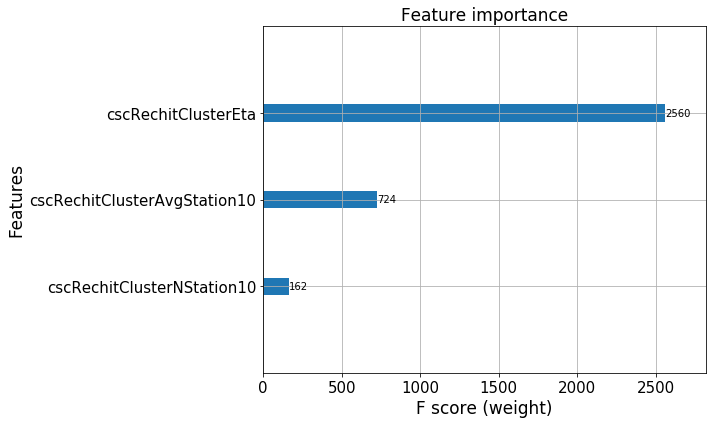

In [64]:
#plot feature importances

model.get_booster().feature_names = [row[1] for row in variables]

ax = xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
fig = ax.figure
fig.set_size_inches(10, 6)
# plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
# plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
ax.title.set_size(17)

ax.yaxis.label.set_size(17)
ax.xaxis.label.set_size(17)
plt.tick_params(axis='both', which='major', labelsize=15)


# plt.draw()
# os.makedirs("../../plots/MuonSystem_Analysis/"+bdt_name)
# plt.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/feature_importance.png', dpi=300)
# 
ax.figure.tight_layout()
ax.figure.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+'/feature_importance.png', dpi=300)

# compare two ROC curves

AUC 0.8913845659719589 0.8924390984281254
background 614
signal 271645


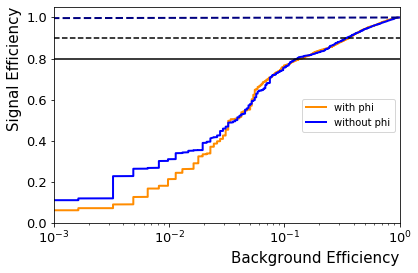

In [37]:

import pickle
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v1.pickle', "rb" ))
model2 = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2.pickle', "rb" ))


# y_pred = model.predict_proba(x_test)[:, 1]
# x_test2 = np.hstack((x_test[:, :3], x_test[:, 4:]))
# y_pred2 = model2.predict_proba(x_test2)[:, 1]

y_pred = model.predict_proba(x_test)[:, 1]
y_pred2 = model2.predict_proba(np.hstack((x_test[:, 0:1], x_test[:, 2:])))[:, 1] #get rid of phi
print('AUC',roc_auc_score(y_test, y_pred), roc_auc_score(y_test, y_pred2))
print('background', np.count_nonzero(y_test==0))
print('signal', np.count_nonzero(y_test==1))



fpr, tpr, thr = roc_curve(y_test, y_pred)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred2)

#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='with phi')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='without phi')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
# plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
# plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
# plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)
# plt.title('Receiver operating characteristic example')
plt.legend(loc="center right")
plt.show()

# signal vs. background (cut based study)

['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\\eta$', 25, 0.5, 2.5]
0.126163007071083 0.0274460021218814
[0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1]
[0.         0.         0.         0.         0.3095788  0.4383699
 0.5295083  0.6153589  0.71965599 0.77092324 0.82726554 0.93584757
 1.         1.        ]
1.8999999999999997


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


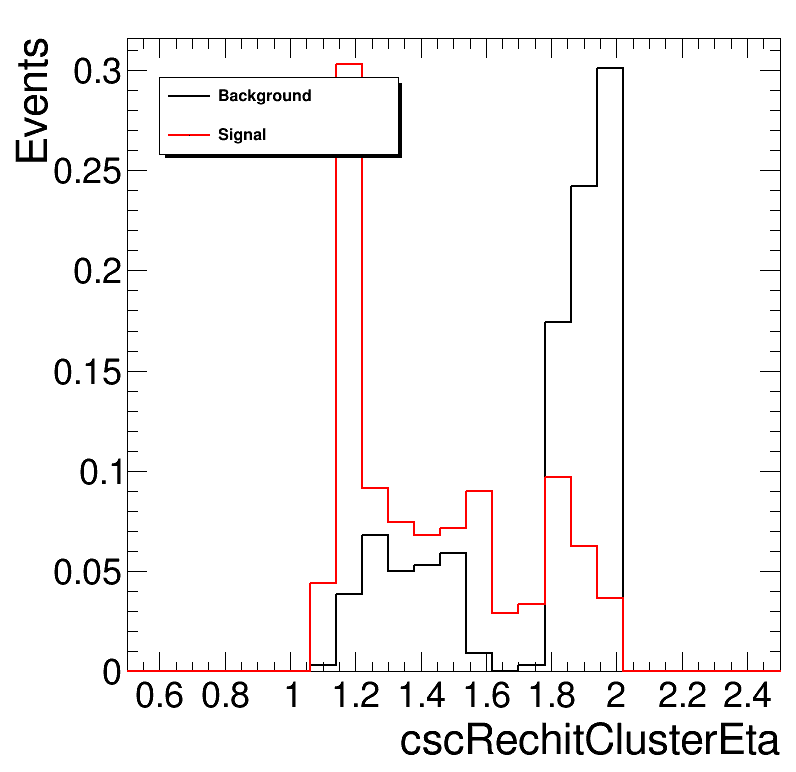

In [109]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.6,0.75,0.92,0.90)
leg = rt.TLegend(0.2,0.80,0.5,0.90)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


sig_flag = 0
lab = ['Background', 'Signal']

for i, var in enumerate(variables):
    if not i == 1:continue
    print(var)
    cond = np.logical_and(x[:,0] == 1, x[:,2] == 3)
    h['bkg'] = create_TH1D(x[:,i][np.logical_and(cond, y==0)], axis_title = [var[1], 'Events'], binning = [var[3], var[4], var[5]])
    h['sig'] = create_TH1D(x[:,i][np.logical_and(cond, y==1)], axis_title = [var[1], 'Events'], binning = [var[3], var[4], var[5]])
    sig_list = x[:,i][np.logical_and(cond, y==1)]
    h['bkg'].SetLineColor(std_color_list[0])
    h['sig'].SetLineColor(std_color_list[1])
    leg.AddEntry(h['bkg'], 'Background')
    leg.AddEntry(h['sig'], 'Signal')

#     h['sig'].SetMaximum(5000)
    #     h[k].SetMinimum(1)
    h['bkg'].DrawNormalized()
    h['sig'].DrawNormalized('same')
    print(h['bkg'].Integral()/np.count_nonzero(y==0), h['sig'].Integral()/np.count_nonzero(y==1))
    eff = []
    threshold = np.arange(0.8, 2.2, 0.1)
    print(threshold)
    for j in threshold:
        cond = sig_list < j
        eff.append(np.count_nonzero(cond)/len(cond)*1.0)
    eff = np.array(eff)
    print(eff)
    idx = np.abs(eff - 0.9).argmin()
    print(threshold[idx])
#     print(k, threshold[idx], eff[idx])
#     print(k, np.count_nonzero(dphi[k] >0.6)/len(dphi[k])*1.0)
# c.SetRightMargin(0.2)

leg.Draw()
# if setlog: 
c.SetLogz()
c.Draw()





# low bdt vs. high bdt

['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\\eta$', 25, 0.5, 2.5]
12


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


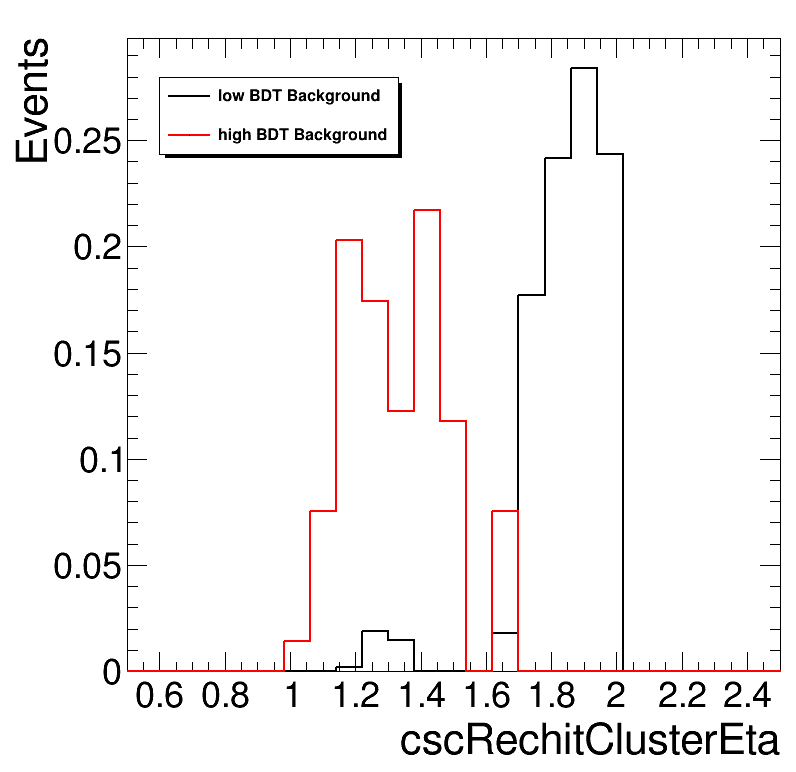

In [85]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.6,0.75,0.92,0.90)
leg = rt.TLegend(0.2,0.80,0.5,0.90)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


sig_flag = 0
lab = ['Background', 'Signal']
x_sig = x[y==sig_flag]
y_pred_sig = model.predict_proba(x_sig)[:, 1]

# h[k] = create_TH2D(np.column_stack((np.array(y_pred[y_test == 0]), np.array(cscRechitClusterSize[indices_test][y_test == 0]))),\
#                    axis_title = ['BDT score','N_{rechits}','Events'], binning=[50,0,1,50,0,600])

# h[k] = h[k].ProfileX()
for i, var in enumerate(variables):
    if not i == 1:continue
    print(var)
    cond = np.logical_and(x_sig[:,0] ==1, x_sig[:,2] ==2)
    h['bkg'] = create_TH1D(x_sig[:,i][np.logical_and(cond, y_pred_sig< WP90_threshold)], axis_title = [var[1], 'Events'], binning = [var[3], var[4], var[5]])
    h['sig'] = create_TH1D(x_sig[:,i][np.logical_and(cond, y_pred_sig>= WP90_threshold)], axis_title = [var[1], 'Events'], binning = [var[3], var[4], var[5]])
    print(np.count_nonzero(x_sig[:,i]<1))

    h['bkg'].SetLineColor(std_color_list[0])
    h['sig'].SetLineColor(std_color_list[1])
    leg.AddEntry(h['bkg'], 'low BDT '+lab[sig_flag])
    leg.AddEntry(h['sig'], 'high BDT '+lab[sig_flag])

#     h['bkg'].SetMaximum(50000)
    #     h[k].SetMinimum(1)
    h['bkg'].DrawNormalized()
    h['sig'].DrawNormalized('same')
# c.SetRightMargin(0.2)

leg.Draw()
# if setlog: 
c.SetLogz()
c.Draw()


